# 2. Data Balance by Label Substitution
---

In this notebook, we will look at the hashtags labels for each image, and fix the imbalance.

## Import Libraries (the following cells are copied from notebook 1)

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os,sys
sys.path.append("../src")

## Create the Target Matrix
Form ```tag_list.txt``` and ```data_list.txt``` in HARRISON dataset, we create a target matrix as a DataFrame.

In [2]:
DATA_LIST = "../HARRISON/data_list.txt"
TAG_LIST = "../HARRISON/tag_list.txt"

# Read files
filename = pd.read_csv(DATA_LIST, names=["filename"], header=None)
hashtag = pd.read_csv(TAG_LIST, names=["labels"], header=None)

# Convert filenames from "instagram_dataset/xxx/yyy.jpg" to "xxx_yyy.jpg"
filename["filename"] = filename["filename"].apply(lambda x: "_".join(x.split("/")[1:]))

# Concatenate filname and labels
target = pd.concat([filename, hashtag], axis=1)
target.head(5)

,filename,labels
0,sea_image_50.jpg,sea instapic instagram trip travel
1,sea_image_1284.jpg,sea
2,sea_image_1122.jpg,sea love
3,sea_image_1679.jpg,beach sea trip island japan
4,sea_image_1736.jpg,sun sand sea sky friend beach thailand trip ad...


In [3]:
# Use vectorizer to generate a one-hot encoding
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(target["labels"])
columns = vectorizer.get_feature_names()
X_df = pd.DataFrame(X.toarray(), columns=columns)

# Combine hashtag encodings with file names
target = pd.concat([target, X_df], axis=1)
target = shuffle(target, random_state=42)

num_images = target.shape[0]
num_hashtags = X_df.shape[1]

## Visualize the data imbalance

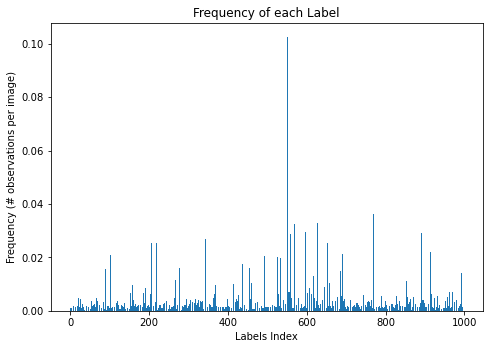

Variance in Frequency: 6.271672470561842e-05
5 Most Common Labels: [('love', 0.10267849363051774), ('friend', 0.06353798163219072), ('beach', 0.052715961173169755), ('family', 0.051687782095742645), ('yellow', 0.046477179652510324)]


In [5]:
from data_balance import Data_Balance,Word_Similarity

db = Data_Balance()
db.visualize_pdf(X_df)

## Balance the data

In [6]:
#create Similarity Matrix. Matrix[i,j] == "path_similarity" between labels i and j
ws = Word_Similarity()
labels = X_df.columns.values
#if you do not yet have a Meanings_Dictionary, use labels=label below. That will generate a default dictionary and csv
ws.load_Similarity_Matrix(labels=None,force_rebuild=True)

Meanings Dictionary successfully loaded from file.
Updating Similarity_Matrix...
Similarity Matrix successfully built.
Similarity Matrix successfully saved to file.


In [7]:
#check which labels have no definitions in the nltk wordnet corpus
#it is recommended that these words are redefined to words that are in the wordnet corpus
#this can be done in model_development/misc/meanings.csv
#BE CAREFUL using Microsoft Excel, which automatically changes 'true' tag to TRUE truth value
#when done, run the next cell
print([l for l in labels if (ws.word2synset(ws.Meanings_Dict[l]) is None)])

['anastasiabeverlyhills', 'and', 'arianagrande', 'arte', 'belieber', 'beliebers', 'bestoftheday', 'beyonce', 'bieber', 'blackandwhite', 'bnw', 'boanoite', 'boho', 'bomdia', 'chanel', 'demilovato', 'doubletap', 'for', 'harrystyles', 'hkig', 'hudabeauty', 'inlove', 'inshot', 'inspo', 'instachile', 'instaselfie', 'instasize', 'jelena', 'justin', 'justinbieber', 'kawaii', 'kendalljenner', 'kidrauhl', 'kimkardashian', 'kyliejenner', 'longhair', 'losangeles', 'mcm', 'mileycyrus', 'newyork', 'niallhoran', 'nyc', 'onedirection', 'onlineshop', 'ootd', 'purposetour', 'redhair', 'rihanna', 'selca', 'selenagomez', 'sepatu', 'sepatumurah', 'spb', 'statigram', 'taylorswift', 'the', 'tweegram', 'uae', 'vsco', 'vscocam', 'vscogood', 'vscogram', 'vscophile', 'vscorussia', 'wcw', 'with', 'zaynmalik']


In [8]:
#rebuild the similarity matrix using the new Meanings Dictionary from disk
#if any updates were made, should say "Meanings Dictionary has been updated on disk."
ws.load_Similarity_Matrix(labels=None,force_rebuild=False)

All structures successfully loaded!


In [9]:
#use Similarity Matrix to balance the Data
Similarity_Matrix = ws.get_Similarity_Matrix(threshold=0.4)
db.load_X_df(X_df)
db.balance_data(Similarity_Matrix)
Balanced_X_df = db.Balanced_X_df

Starting Variance: 6.271672470561842e-05
Completed 1 iterations! | Ending Variance: 1.8729301573045893e-05


## Visualize the balanced data

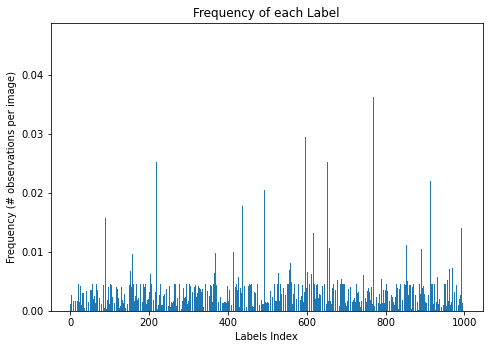

Variance in Frequency: 1.8729301573045893e-05
5 Most Common Labels: [('yellow', 0.046477179652510324), ('snow', 0.03854800202150463), ('bored', 0.03690988620323092), ('school', 0.03617796211421501), ('tired', 0.03433072512765105)]


In [10]:
db.visualize_pdf(Balanced_X_df)

In [11]:
import os

#save balanced tag lists to files
tag_list_pathname = os.path.join("..","HARRISON","tag_list_similarity_balanced.txt")
data_list_pathname = os.path.join("..","HARRISON","data_list_similarity_balanced.txt")

tag_list_oversampled_df = Balanced_X_df.dot((Balanced_X_df.columns.to_numpy() + " "))
data_list_oversampled_df = target.loc[Balanced_X_df.index,'filename']

tag_list_oversampled_df.to_csv(tag_list_pathname,header=False,index=False)
data_list_oversampled_df.to_csv(data_list_pathname,header=False,index=False)